## Linear Discriminant Analysis (LDA) (Supervised)

Linear Discriminant Analysis (LDA) is most commonly used as dimensionality reduction technique in the pre-processing step for pattern-classification and machine learning applications. The goal is to project a dataset onto a lower-dimensional space with good class-separability in order avoid overfitting ("curse of dimensionality") and also reduce computational costs. Source: 

(http://nbviewer.jupyter.org/github/rasbt/pattern_classification/blob/master/dimensionality_reduction/projection/linear_discriminant_analysis.ipynb)


Where PCA attempts to find the orthogonal component axes of maximum variance, with LDA we are also interested in finding the feature subspace that optimizes **class separability**. Both are linear transformation techniques, but LDA is supervised.

LDA tries to minimize the intra class variations and maximize the inter class variations.

One assumption in LDA is that the data is **normally distributed**. Also we assume that the classes have identical covariance matrices and features are statistically independent from each other. However, if one or more of assumptions is slightly violated, the LDA still works reasonably well in some cases.

keysteps:
+ Step 1: --> standardize the d-dim dataset
+ Step 2: --> for each class: compute the d-dim mean vector
+ Step 3.1: --> Constuct the Within-class Scatter Matrix $S(w)$
+ Step 3.2: --> Construct the Between-class Scatter Matrix $S(b)$
+ Step 4: --> Compute eigenvectors and corresponding eigenvalues of Matrix $S(w)S(b)$
+ Step 5: --> Choose the k eigenvectors that correspond to the k largest eigenvalues to construct the d x k-dim transformation matrix W (eigenvectors are the columns of this matrix)
+ Step 6: --> project the samples onto the new feature subspace using the W-matrix

In-depth stats and explanations:
https://www.doc.ic.ac.uk/~dfg/ProbabilisticInference/old_IDAPILecture15.pdf

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import sys
sys.path.insert(0, 'helper_functions/')

In [2]:
df_wine = pd.read_csv('https://raw.githubusercontent.com/rasbt/python-machine-learning-book/master/code/datasets/wine/wine.data', header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash', 
                   'Alcalinity of ash', 'Magnesium', 'Total phenols', 
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines', 
                   'Proline']
df_wine.head()

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [3]:
# Test, train set
X = df_wine.iloc[:, 1:].values 
y = df_wine.iloc[:, 0].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, 
                                                    random_state = 0)

# no features and class_labels
n_features = X.shape[1] # num features
class_labels = np.unique(y)

### Manually construct a LDA. Steps: 

In [4]:
# Step 1: --> standardize the d-dim dataset
from sklearn.preprocessing import StandardScaler
sc= StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.fit_transform(X_test)

Note: standardization does **not** change the overall results of an LDA and thus may be optional. Yes, the scatter matrices will be different depending on whether the features were scaled or not. In addition, the eigenvectors will be different as well. However, **the important part is that the eigenvalues will be exactly the same as well as the final projects** -- the only difference you'll notice is the scaling of the component axes

In [5]:
# Step 2: --> calculating the mean vectors for each class
np.set_printoptions(precision=4)

mean_vectors = []
for label in class_labels:
    mean_vectors.append(np.mean(X_train_std[y_train == label], axis=0)) 
    print ('Mean vectors {} : {}\n'.format(label, mean_vectors[label - 1]))

Mean vectors 1 : [ 0.9259 -0.3091  0.2592 -0.7989  0.3039  0.9608  1.0515 -0.6306  0.5354
  0.2209  0.4855  0.798   1.2017]

Mean vectors 2 : [-0.8727 -0.3854 -0.4437  0.2481 -0.2409 -0.1059  0.0187 -0.0164  0.1095
 -0.8796  0.4392  0.2776 -0.7016]

Mean vectors 3 : [ 0.1637  0.8929  0.3249  0.5658 -0.01   -0.9499 -1.228   0.7436 -0.7652
  0.979  -1.1698 -1.3007 -0.3912]



In [6]:
# Step 3.1: --> Constuct the Within-class Scatter Matrix

# Check carefully if class labels are uniformly distributed. This is not the case! **
np.bincount(y_train)[1:]

array([40, 49, 35])

In [8]:
S_W = np.zeros((n_features, n_features))

for label, mv in zip(range(1, 4), mean_vectors):
    class_scatter = np.cov(X_train_std[y_train == label].T) # ** so we need np.cov
    S_W += class_scatter
    
print ('Within-class Scatter Matrix:{}\n {}'.format(S_W.shape, S_W))

Within-class Scatter Matrix:(13, 13)
 [[ 1.2458e+00  5.1385e-02 -3.2946e-02 -8.9533e-02  1.1546e-01  2.4539e-01
   1.5011e-01 -5.5687e-02  9.9079e-02  4.8786e-01  2.3763e-02 -6.9716e-03
   1.3421e-01]
 [ 5.1385e-02  2.1547e+00  2.2434e-01  3.5434e-01 -1.9660e-01  3.6054e-02
  -5.4027e-03  3.4017e-01  1.6840e-01 -1.6748e-01 -3.5755e-01  1.7728e-01
  -2.5417e-01]
 [-3.2946e-02  2.2434e-01  2.5250e+00  1.4581e+00  3.7029e-01  3.3665e-01
   2.3874e-01  4.7135e-01  3.0912e-02 -5.6416e-02  1.2842e-01  2.3408e-01
  -1.0665e-01]
 [-8.9533e-02  3.5434e-01  1.4581e+00  1.9805e+00  8.1397e-02  1.1795e-01
   1.2522e-01  3.2764e-01 -3.7325e-02 -1.2945e-01  6.1622e-02  2.5545e-01
  -1.2909e-01]
 [ 1.1546e-01 -1.9660e-01  3.7029e-01  8.1397e-02  2.7048e+00  1.6042e-01
   1.4980e-01 -7.3692e-01  5.9847e-01  7.6183e-02  1.1849e-01 -1.1342e-01
   3.1797e-01]
 [ 2.4539e-01  3.6054e-02  3.3665e-01  1.1795e-01  1.6042e-01  1.2976e+00
   6.1556e-01 -1.1631e-01  7.2183e-01  3.0402e-01  7.1530e-03  3.6115e-01

This a a crucial matrix because the approach of the LDA is to project all the data points into new space,of lower dimension, maximizing the between-class separability **while minimising their within-class variability**

In [10]:
# Step 3.2: --> Construct the Between-class Scatter Matrix
overal_average = np.mean(X_train_std, axis=0)

S_B = np.zeros((n_features, n_features))

for i, mv in enumerate(mean_vectors):
    n = X_train[y_train == i + 1, :].shape[0]
    mv = mv.reshape(n_features, 1) # column vector
    overal_average = overal_average.reshape(n_features, 1)
    
    S_B += n * (mv - overal_average).dot((mv - overal_average).T)

print ('Between-class Scatter Matrix:{}\n {}'.format(S_B.shape, S_B))

Between-class Scatter Matrix:(13, 13)
 [[ 72.549   10.1509  30.4349 -36.9554  21.4982  34.6692  31.1055 -18.3914
   10.7602  51.4069  -7.5057  10.231   72.2652]
 [ 10.1509  39.0069  15.3272  22.8751   0.4806 -39.5667 -51.7325  31.3465
  -32.6026  44.4773 -50.8565 -55.7604 -13.8346]
 [ 30.4349  15.3272  16.0274  -7.244    8.2744   1.4636  -3.4672   2.2736
   -5.5304  32.5455 -17.8161 -12.5503  23.2642]
 [-36.9554  22.8751  -7.244   39.7512 -12.8366 -50.8027 -57.6929  34.678
  -30.9313   1.6344 -33.3403 -47.886  -54.6782]
 [ 21.4982   0.4806   8.2744 -12.8366   6.5404  13.26    12.9885  -7.7306
    5.482   12.7262   1.1248   6.8773  23.0242]
 [ 34.6692 -39.5667   1.4636 -50.8027  13.26    69.0574  81.1418 -48.873
   45.4488 -19.4945  55.2712  72.475   62.8312]
 [ 31.1055 -51.7325  -3.4672 -57.6929  12.9885  81.1418  97.0227 -58.4985
   55.5076 -33.5931  71.1001  89.7251  66.7143]
 [-18.3914  31.3465   2.2736  34.678   -7.7306 -48.873  -58.4985  35.2729
  -33.5083  20.6153 -43.0446 -54.20

In [11]:
# Step 4: --> Compute eigenvectors and corresponding eigenvalues of Matrix

# instead of performing eigendecomposition on the covariance matrix like in PCA, 
# we solve the generalized eigenvalue problem of the matrix S(w).S(b)

eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

In [13]:
for i in range(len(eigen_vals)):
    eigv = eigen_vecs[:,i].reshape(n_features ,1) 
    np.testing.assert_array_almost_equal(np.linalg.inv(S_W).dot(S_B).dot(eigv), 
                                         eigen_vals[i] * eigv, 
                                         decimal=6, err_msg='', verbose=True)
print('ok')

ok


discr [0.7431924459744844, 0.2568075540255153, 1.7343072472683015e-16, 6.5605621439508e-17, 4.6657373152547295e-17, 2.2352325190860184e-17, 2.2352325190860184e-17, 5.549132693163771e-18, 5.549132693163771e-18, 4.359808798184487e-18, -1.7915305145446203e-17, -1.7915305145446203e-17, -5.596636627795896e-17]


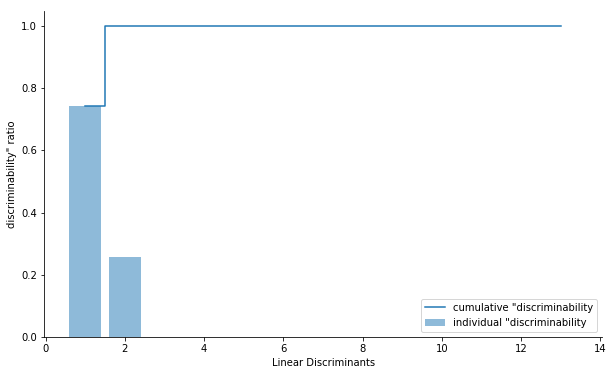

In [14]:
# Step 5: --> Choose the k eigenvectors that correspond to the k largest eigenvalues
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]

# sort by decreasing eigenvalues
eigen_pairs = sorted(eigen_pairs, key=lambda x: x[0], reverse=True)

# plot 
total = sum(eigen_vals.real)
discr = [(i/ total) for i in sorted(eigen_vals.real, reverse=True)]
cum_discr = np.cumsum(discr)
print ('discr %s' % discr)

from utilities import remove_borders
fig, ax = plt.subplots(figsize=[10,6])

ax.bar(range(1, 14), discr, alpha=0.5, align='center',
       label='individual "discriminability')
ax.step(range(1, 14), cum_discr, where='mid', 
        label='cumulative "discriminability')
ax.set(ylabel = 'discriminability" ratio', xlabel = 'Linear Discriminants')
ax.legend(loc='best')
remove_borders(ax)

First 2 linear discriminants capture +/- 100% of the the useful information

In [15]:
# construct the d x k-dim transformation matrix W
W = np.hstack((eigen_pairs[0][1][:, np.newaxis].real, 
              eigen_pairs[1][1][:, np.newaxis].real))

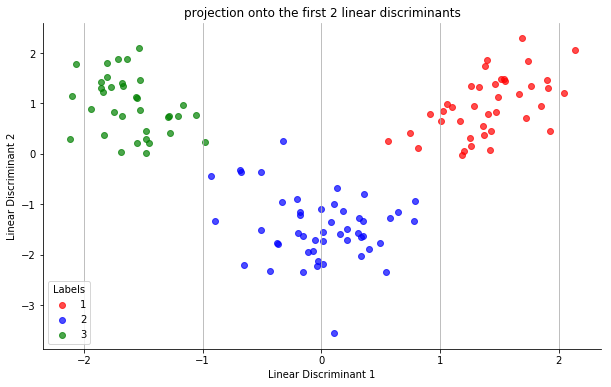

In [16]:
# Step 6: --> project the samples onto the new feature subspace using the W-matrix
X_train_lda = X_train_std.dot(W)
colors = ['r', 'b', 'g']

fig, ax = plt.subplots(figsize=[10,6])
for label, color in zip(np.unique(y_train), colors):
    ax.scatter(X_train_lda[y_train == label, 0] * (-1),
                X_train_lda[y_train == label, 1] * (-1),
                c=color, label=label, alpha=.7)

ax.set(xlabel = 'Linear Discriminant 1', ylabel = 'Linear Discriminant 2',
      title = 'projection onto the first 2 linear discriminants')
ax.legend(loc='best', title='Labels')
ax.xaxis.grid()
remove_borders(ax)